In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import folium
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

# Data Cleaning

**LA Crime Data**

In [2]:
# load the data
df1 = pd.read_csv("20-25.csv")
df2 = pd.read_csv("10-19.csv")
df2 = df2.rename(columns={'AREA ': 'AREA'})


# merge 
df = pd.concat([df1, df2], ignore_index=True)


# select required cols and non-zero rows
data = df[['DATE OCC','TIME OCC', 'AREA', 'Crm Cd', 'LAT', 'LON']]
data = data[data['LON'] != 0]
data = data[data['LAT'] != 0]


# delete edge data to ensure normal boundary range  
UB = data['LAT'].quantile(0.95)
LB = data['LAT'].quantile(0.05)
data = data[data['LAT'] <= UB]
data = data[data['LAT'] >= LB]

UB = data['LON'].quantile(0.95)
LB = data['LON'].quantile(0.05)
data = data[data['LON'] <= UB]
data = data[data['LON'] >= LB]

**Threat Level Data**

In [3]:
threat = pd.read_csv("crime_threat.csv").iloc[:, [1, -1]]
threat.columns = ['Crm Cd', 'threat level']

**Merge and Save**

In [4]:
data = pd.merge(data, threat, on='Crm Cd', how='left')
data.to_csv('data_cleaned.csv', index=False)

# Tidal Patten in LA

In [5]:
df = pd.read_csv("data_cleaned.csv")

In [6]:
# split data by time period
time_split = 4

df_cut_by_time = {}

for period in range(time_split):
    period_start = period * (24 // time_split)
    period_end = period_start + (24 // time_split)
    period_key = f"{period_start}:00-{period_end}:00"


    if period_end == 24:
        period_df = df[df['TIME OCC'] >= period_start * 100].copy()
    else:
        period_df = df[
            (df['TIME OCC'] >= period_start * 100) &
            (df['TIME OCC'] < period_end * 100)
        ].copy()

    df_cut_by_time[period_key] = period_df





# areas having most crime records
def period_frequency(period_df):
    fequency = np.zeros(21)
    for area_id in range(1, 22):  # 21 regions in total
        try:
            region_df = period_df.groupby(by='AREA').get_group(area_id)
            fequency[area_id-1] = region_df.shape[0]  
        except KeyError:
            fequency[area_id-1] = 0
    return fequency
    
print(np.argsort(period_frequency(df_cut_by_time['0:00-6:00']))[::-1][:3])
print(np.argsort(period_frequency(df_cut_by_time['6:00-12:00']))[::-1][:3])
print(np.argsort(period_frequency(df_cut_by_time['12:00-18:00']))[::-1][:3])
print(np.argsort(period_frequency(df_cut_by_time['18:00-24:00']))[::-1][:3])

[ 5 11  0]
[11  2 13]
[ 2 11 13]
[11  2 14]


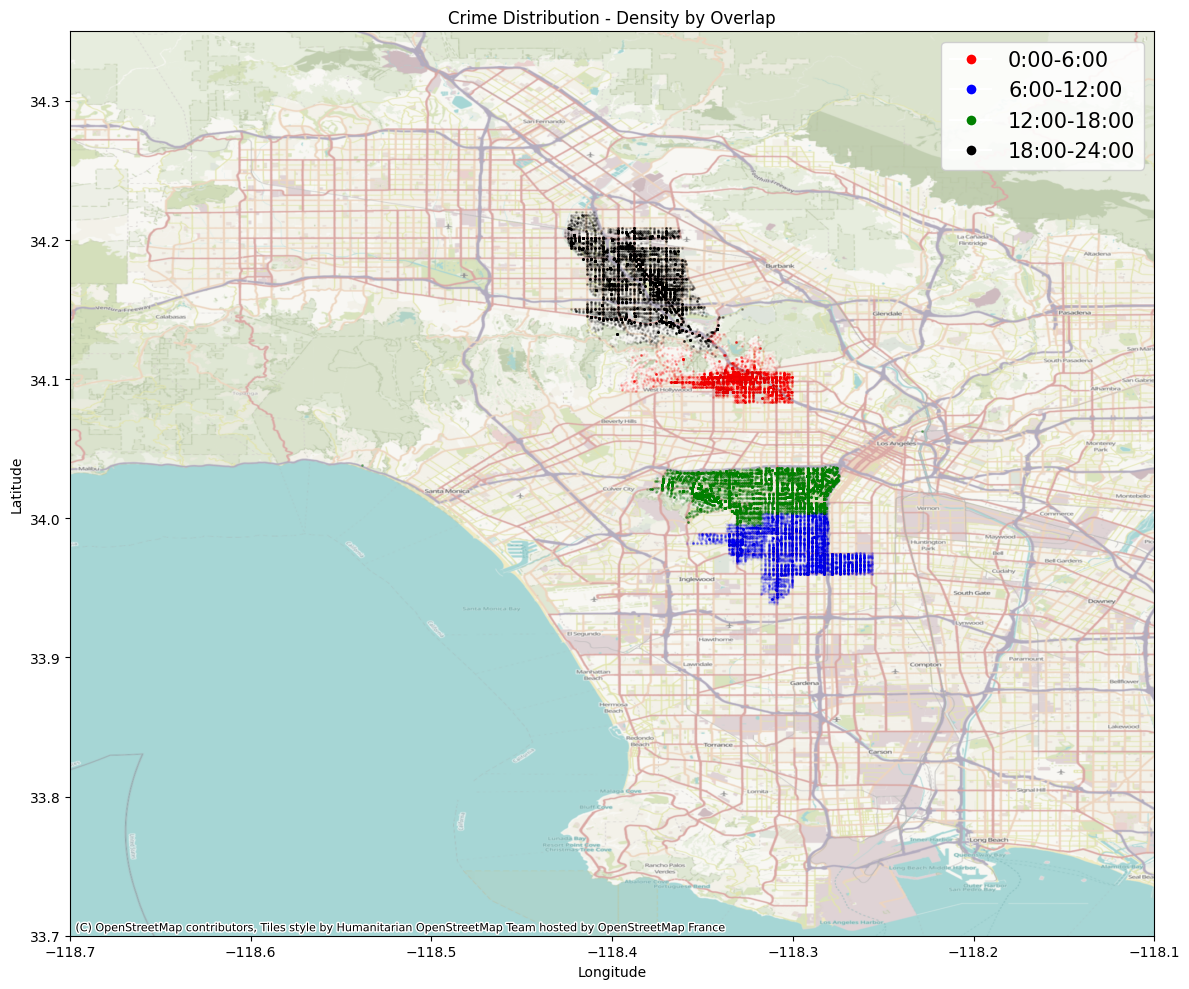

In [7]:
LA_BOUNDS = {
    'west': -118.7,   
    'east': -118.1,    
    'south': 33.7,    
    'north': 34.35    
}

plt.figure(figsize=(12, 10))
ax = plt.subplot(111)

df1 = df_cut_by_time['0:00-6:00'].groupby(by='AREA').get_group(6)
df2 = df_cut_by_time['6:00-12:00'].groupby(by='AREA').get_group(12)
df3 = df_cut_by_time['12:00-18:00'].groupby(by='AREA').get_group(3)
df4 = df_cut_by_time['18:00-24:00'].groupby(by='AREA').get_group(15)


plt.scatter(df1['LON'], df1['LAT'], 
            alpha=0.03,  
            s=1,         
            color='red',
            label='0:00-6:00'  
           )

plt.scatter(df2['LON'], df2['LAT'], 
            alpha=0.03,  
            s=1,         
            color='blue',
            label='6:00-12:00')


plt.scatter(df3['LON'], df3['LAT'], 
            alpha=0.03,  
            s=1,         
            color='green',
            label='12:00-18:00'  
           )

plt.scatter(df4['LON'], df4['LAT'], 
            alpha=0.03,  
            s=1,         
            color='black',
            label='18:00-24:00'  
           )

ax.set_xlim(LA_BOUNDS['west'], LA_BOUNDS['east'])
ax.set_ylim(LA_BOUNDS['south'], LA_BOUNDS['north'])

ctx.add_basemap(ax, crs='EPSG:4326', zoom=12, alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crime Distribution - Density by Overlap')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='0:00-6:00'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='6:00-12:00'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='12:00-18:00'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='18:00-24:00')
]

plt.legend(handles=legend_elements, loc='upper right', framealpha=0.9, fontsize=15)

plt.tight_layout()
plt.show()

# Interactive Map

In [8]:
n = 5
time_split = 4

for group_id in range(1, 21):
    # Area Data
    region_df = df.groupby(by='AREA').get_group(group_id)

    # Bound
    Region_Bound = {
        'west': region_df['LON'].quantile(0.01) - 0.008,
        'east': region_df['LON'].quantile(0.99) + 0.008,
        'south': region_df['LAT'].quantile(0.01) - 0.008,
        'north': region_df['LAT'].quantile(0.99) + 0.008
    }

    # Make Grids
    lat_bins = np.linspace(Region_Bound['south'], Region_Bound['north'], n + 1)
    lon_bins = np.linspace(Region_Bound['west'], Region_Bound['east'], n + 1)

    # Initialize Map
    map_center = [(Region_Bound['north'] + Region_Bound['south']) / 2,
                (Region_Bound['east'] + Region_Bound['west']) / 2]
    m = folium.Map(location=map_center, zoom_start=13)

    # Plot Region Bounds on Map
    region_boundary_coords = [
        [(Region_Bound['west'], Region_Bound['south']),
        (Region_Bound['east'], Region_Bound['south']),
        (Region_Bound['east'], Region_Bound['north']),
        (Region_Bound['west'], Region_Bound['north']),
        (Region_Bound['west'], Region_Bound['south'])] 
    ]

    folium.Rectangle(
        bounds=[
            [Region_Bound['south'], Region_Bound['west']],   # [lat_min, lon_min]
            [Region_Bound['north'], Region_Bound['east']]    # [lat_max, lon_max]
        ],
        color='black',
        weight=3,
        dash_array='8,4',      
        fill=False,
        popup=f"LAPD Patrol Area {group_id}",
        tooltip=f"Area {group_id} Boundary"
    ).add_to(m)


    # Save GeoJSON for Each Time Period
    layer_data = {}

    for period in range(time_split):
        period_start = period * (24 // time_split)
        period_end = period_start + (24 // time_split)
        period_key = f"{period_start}:00-{period_end}:00"

        # Select Period Data
        if period_end == 24:
            period_df = region_df[region_df['TIME OCC'] >= period_start * 100].copy()
        else:
            period_df = region_df[
                (region_df['TIME OCC'] >= period_start * 100) &
                (region_df['TIME OCC'] < period_end * 100)
            ].copy()

        if period_df.empty:
            layer_data[period_key] = {"type": "FeatureCollection", "features": []}
            continue

        # Assign Data by Grids
        period_df['lat_bin'] = pd.cut(period_df['LAT'], bins=lat_bins, labels=range(n))
        period_df['lon_bin'] = pd.cut(period_df['LON'], bins=lon_bins, labels=range(n))

        # Calculate Grid Risk 
        grid_risk = period_df.groupby(['lat_bin', 'lon_bin'], observed=True)['threat level'].mean()
        top_5_grids = grid_risk.nlargest(5).index.tolist()

        # Construct GeoJSON Features
        features = []
        for (lat_bin, lon_bin) in top_5_grids:
            lat_min, lat_max = lat_bins[int(lat_bin)], lat_bins[int(lat_bin) + 1]
            lon_min, lon_max = lon_bins[int(lon_bin)], lon_bins[int(lon_bin) + 1]

            coords = [
                [lon_min, lat_min],
                [lon_max, lat_min],
                [lon_max, lat_max],
                [lon_min, lat_max],
                [lon_min, lat_min]
            ]
            polygon = Polygon(coords)
            
            feature = {
                "type": "Feature",
                "properties": {
                    "risk": float(grid_risk[(lat_bin, lon_bin)]),
                    "period": period_key
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [coords]
                }
            }
            features.append(feature)

        layer_data[period_key] = {"type": "FeatureCollection", "features": features}






    for period_key, geojson in layer_data.items():
        if geojson["features"]: 
            folium.GeoJson(
                geojson,
                name=period_key,
                style_function=lambda x: {
                    'fillColor': "#FF0000",
                    'color': 'black',
                    'weight': 1,
                    'fillOpacity': 0.4
                },
                tooltip=folium.GeoJsonTooltip(fields=['risk'], aliases=['Avg Threat:'])
            ).add_to(m)


    folium.LayerControl(collapsed=False).add_to(m)

    # Save as HTML
    m.save(f"output//region_{group_id}.html")